# SSD: Visualization

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

## Class specification

In [2]:
from utils.datasets import DataManager

In [3]:
dataset_name = 'VOC2007'
dataset_manager = DataManager(dataset_name)
ground_truth_data = dataset_manager.load_data()
class_names = dataset_manager.class_names
print('Found:',len(ground_truth_data),'images \nClass names: \n', class_names)

Found: 9963 images 
Class names: 
 ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [4]:
dataset_name = 'VOC2007'
class_names = ['background', 'diningtable', 'chair']
dataset_manager = DataManager(dataset_name, class_names)
ground_truth_data = dataset_manager.load_data()
class_names = dataset_manager.class_names
print('Found:',len(ground_truth_data),'images \nClass names: \n', class_names)

Found: 1275 images 
Class names: 
 ['background', 'diningtable', 'chair']


## Prior/default box creator

In [5]:
from models.ssd import SSD300
from utils.boxes import create_prior_boxes

Using TensorFlow backend.


In [6]:
model = SSD300()
prior_boxes = create_prior_boxes(model)
print('Prior boxes shape:', prior_boxes.shape)
print('Prior box example:', prior_boxes[777])

Prior boxes shape: (7308, 4)
Prior box example: [ 0.77894737  0.12105263  0.87894737  0.22105263]


## Prior boxes 

In [7]:
from utils.visualizer import draw_image_boxes
from utils.preprocessing import load_image

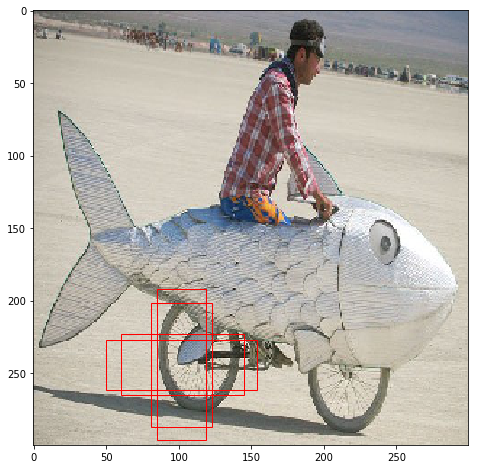

In [8]:
image_path = '../images/fish-bike.jpg'
input_shape = model.input_shape[1:3]
image_array = load_image(image_path, input_shape)
box_coordinates = prior_boxes[6080:6084, :]
draw_image_boxes(box_coordinates, image_array)

In [9]:
#box_coordinates = prior_boxes[5400:6900, :]
#draw_image_boxes(box_coordinates, image_array)

## Ground truths

Data sample: 
 [[ 0.39259259  0.51428571  0.6037037   0.75238095  0.          0.          1.        ]
 [ 0.00740741  0.65714286  0.64444444  1.          0.          1.          0.        ]]


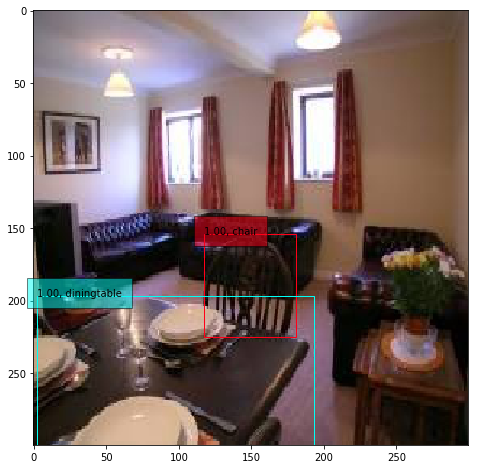

In [10]:
image_name = sorted(list(ground_truth_data.keys()))[1019]
box_data = ground_truth_data[image_name]
print('Data sample: \n', box_data)
image_prefix = dataset_manager.image_prefix
image_path = image_prefix + image_name
class_decoder = dataset_manager.arg_to_class
image_array = load_image(image_path, input_shape)
draw_image_boxes(box_data, image_array, class_decoder)

## Assigned prior boxes without regression

In [11]:
from utils.boxes import assign_prior_boxes

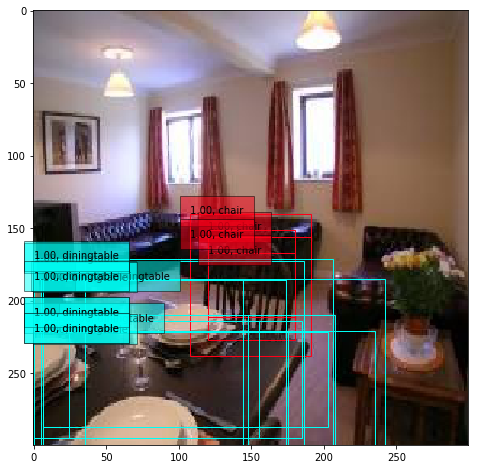

In [12]:
#prior_box_manager = PriorBoxManager(prior_boxes, num_classes=num_classes)
num_classes = len(class_names)
box_scale_factors = [.1, .1, .2, .2]
assigned_boxes = assign_prior_boxes(prior_boxes, box_data,
                                    num_classes, box_scale_factors,
                                    regress=False,
                                    overlap_threshold=.6)
positive_mask = assigned_boxes[:, 4] != 1
positive_boxes = assigned_boxes[positive_mask]
draw_image_boxes(positive_boxes, image_array, class_decoder)

## Assigned prior boxes with regression

In [13]:
"""
assigned_regressed_boxes = assign_prior_boxes(prior_boxes, box_data,
                                              num_classes, box_scale_factors,
                                              regress=True)
positive_mask = assigned_regressed_boxes[:, 4] != 1
encoded_positive_boxes = assigned_regressed_boxes[positive_mask]
draw_image_boxes(assigned_regressed_boxes, image_array, class_decoder)
"""

'\nassigned_regressed_boxes = assign_prior_boxes(prior_boxes, box_data,\n                                              num_classes, box_scale_factors,\n                                              regress=True)\npositive_mask = assigned_regressed_boxes[:, 4] != 1\nencoded_positive_boxes = assigned_regressed_boxes[positive_mask]\ndraw_image_boxes(assigned_regressed_boxes, image_array, class_decoder)\n'

## Assigned decoded boxes

In [14]:
from utils.boxes import decode_boxes

In [15]:
"""
assigned_decoded_boxes = decode_boxes(assigned_regressed_boxes,
                                      prior_boxes, box_scale_factors)
decoded_positive_boxes = assigned_decoded_boxes[positive_mask]
draw_image_boxes(decoded_positive_boxes, image_array, class_decoder)
"""

'\nassigned_decoded_boxes = decode_boxes(assigned_regressed_boxes,\n                                      prior_boxes, box_scale_factors)\ndecoded_positive_boxes = assigned_decoded_boxes[positive_mask]\ndraw_image_boxes(decoded_positive_boxes, image_array, class_decoder)\n'

## Data augmentation

In [16]:
from utils.data_augmentation import ImageGenerator
from utils.preprocessing import load_image
from utils.visualizer import plot_images
from utils.train import split_data
import numpy as np

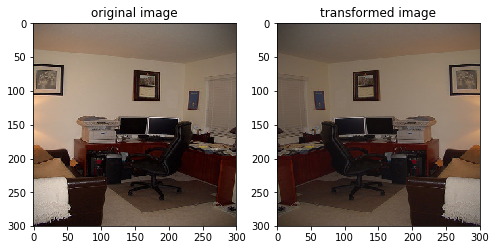

In [17]:
batch_size = 1
train_keys, validation_keys = split_data(ground_truth_data, training_ratio=.8)
image_generator = ImageGenerator(ground_truth_data,
                                 prior_boxes,
                                 num_classes,
                                 box_scale_factors,
                                 batch_size,
                                 input_shape,
                                 train_keys, validation_keys,
                                 image_prefix,
                                 vertical_flip_probability=0,
                                 horizontal_flip_probability=1)

generated_data = next(image_generator.flow(mode='demo'))
generated_input = generated_data[0]['input_1']
generated_output = generated_data[1]['predictions']
generated_image = np.squeeze(generated_input[0]).astype('uint8')
validation_image_name = image_prefix + validation_keys[0]
original_image = load_image(validation_image_name, input_shape)
plot_images(original_image, generated_image)

## Modified ground-truth

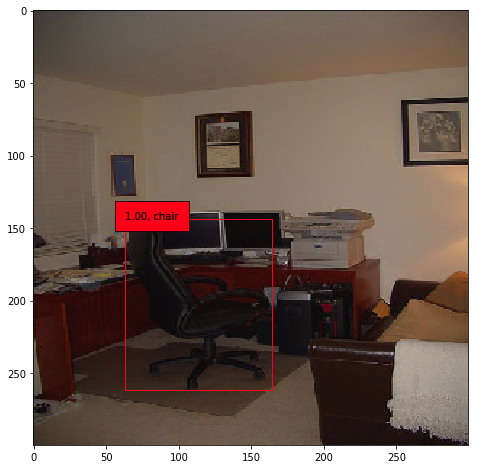

In [18]:
generated_encoded_boxes = np.squeeze(generated_output)
generated_boxes = decode_boxes(generated_encoded_boxes, prior_boxes,
                                                  box_scale_factors)
positive_mask = generated_boxes[:, 4] != 1
generated_positive_boxes = generated_boxes[positive_mask]
draw_image_boxes(generated_positive_boxes, generated_image, class_decoder)

## Detecting objects

In [19]:
import glob
from utils.inference import predict
from utils.preprocessing import get_image_size
from utils.preprocessing import load_pil_image
from scipy.misc import imread
from utils.preprocessing import image_to_array
from utils.datasets import get_class_names
from utils.datasets import get_arg_to_class

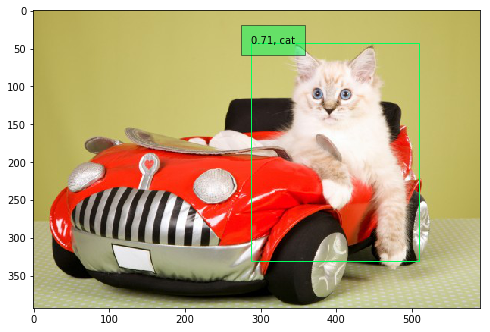

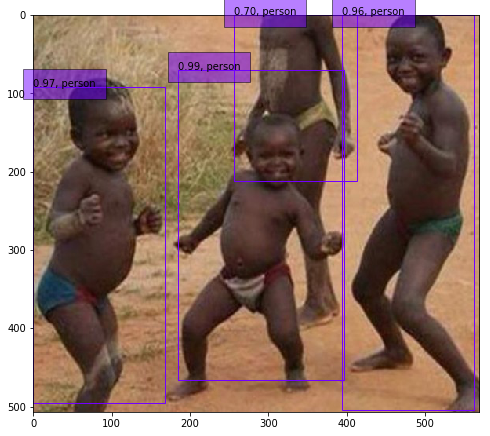

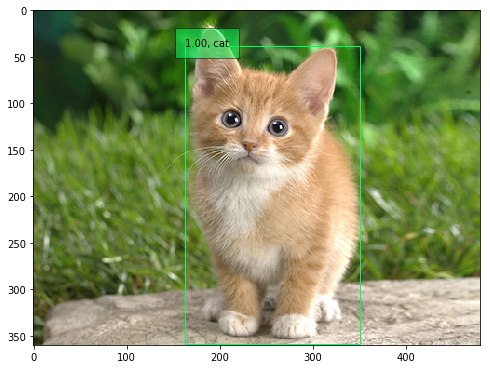

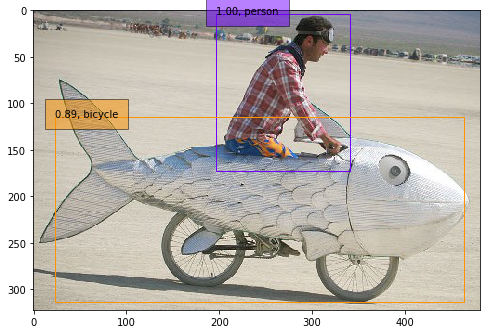

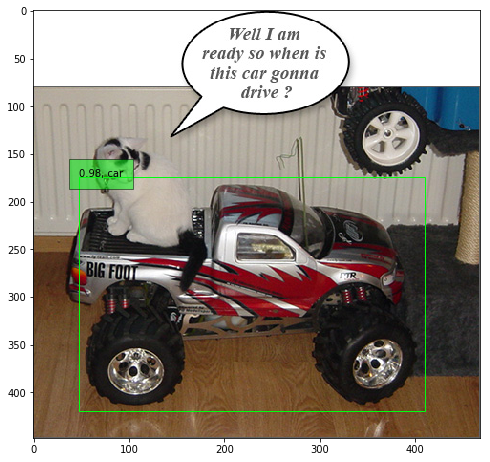

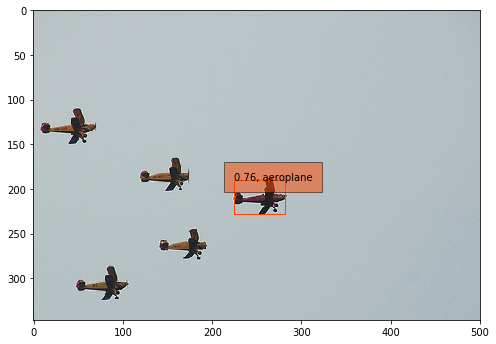

In [31]:
weights_path = '../trained_models/weights_SSD300.hdf5'
image_paths = glob.glob('../images/*.jpg')
class_names = get_class_names(dataset_name)
class_decoder = get_arg_to_class(class_names)
num_classes = len(class_names)
probability_threshold = .6
model = SSD300(num_classes=21, weights_path='../trained_models/weights_SSD300.hdf5')
for image_path in image_paths:
    image_array = load_image(image_path, input_shape)
    original_image_array = image_to_array(load_pil_image(image_path)) 
    original_image_size = get_image_size(image_path)
    selected_boxes = predict(model, image_array, prior_boxes, original_image_size,
                             num_classes, probability_threshold, .5)
    draw_image_boxes(selected_boxes, original_image_array, class_decoder,
                                                         normalized=False)